Alexander W. Criswell 9/17/25

Notebook to test single-pulsar sensitivity estimates for the phased-array approach to multiband detection.

In [34]:
import numpy as np
import scipy.linalg as sl
import matplotlib.pyplot as plt
import glob, pickle, json
import healpy as hp
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import os; os.environ['TEMPO2'] = '/home/awc/.local/share/mamba/envs/gwenv-1/share/tempo2'
from enterprise.pulsar import Pulsar as ePulsar

We're using the IPTA DR3-like dataset developed by Polina Petrov and Levi Schult:

The following paths point to the location of the data files (tim), parameter files (par) and noise files. 

In [4]:
pardir = '/datadisk/data/NANOGrav/ipta_dr3_like/'
timdir = '/datadisk/data/NANOGrav/ipta_dr3_like/'
# noise_dir = '/Users/hazboun/GoogleDrive/NANOGrav_Detection/11yr_stochastic_analysis'
noise_dir = '/datadisk/data/NANOGrav/ipta_dr3_like/'
pars = sorted(glob.glob(pardir+'*.par'))
tims = sorted(glob.glob(timdir+'*.tim'))
noise_files = [noise_dir+'all_pulsar_IRN.json'] #sorted(glob.glob(noise_dir+'*.json'))

In [5]:
len(noise_files), len(pars), len(tims)

(1, 116, 116)

Here we collate the noise parameters into one large dictionary.

In [6]:
rnoise = {}

for nf in noise_files:
    with open(nf,'r') as fin:
        rnoise.update(json.load(fin))

In [7]:
rnoise

{'B1855+09': {'log10_A': -15.99647656746853, 'gamma': 3.5396469439334792},
 'B1937+21': {'log10_A': -13.463605830493172, 'gamma': 3.374032874115919},
 'B1953+29': {'log10_A': -13.002302769035374, 'gamma': 2.5736345755399452},
 'J0023+0923': {'log10_A': -13.241974156069762, 'gamma': 0.46760456143188645},
 'J0030+0451': {'log10_A': -16.049634395288948, 'gamma': 4.155434498262419},
 'J0340+4130': {'log10_A': -16.898237941228622, 'gamma': 3.26486627714507},
 'J0613-0200': {'log10_A': -13.618259822053759, 'gamma': 1.9494203530647316},
 'J0636+5128': {'log10_A': -13.410596521398292, 'gamma': 1.0565090211902983},
 'J0645+5158': {'log10_A': -17.117127871059605, 'gamma': 3.2348280360630493},
 'J0740+6620': {'log10_A': -16.84905967304969, 'gamma': 3.345698406975421},
 'J0931-1902': {'log10_A': -16.74290521185594, 'gamma': 3.286168819612569},
 'J1012+5307': {'log10_A': -12.799780392300217, 'gamma': 1.2630304434221191},
 'J1024-0719': {'log10_A': -15.704921441426094, 'gamma': 2.4567633960459974},


Following the hasasia tutorial, the following loop loads the pulsars into `enterprise.pulsar.Pulsar` class instances. This uses a pulsar timing package in the background, either `Pint` or `TEMPO2` (via the Python wrapper `libstempo`).

In [8]:
ePsrs = []
for par,tim in zip(pars,tims):
    ePsr = ePulsar(par, tim,  ephem='DE436')
    ePsrs.append(ePsr)
    print('\rPSR {0} complete'.format(ePsr.name),end='',flush=True)

PSR B1855+09 complete[tempo2Util.C:396] Warning: [MISC1] Unknown parameter in par file:  DMDATA
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.
[tempo2Util.C:396] Warning: [PAR2] Have not set a DM epoch. The period epoch will be used instead. B1855+09.par
PSR B1953+29 complete

PSR J0030+0451 complete

PSR J0125-2327 complete

PSR J0340+4130 complete

PSR J0437-4715 complete

PSR J0509+0856 complete

PSR J0557+1551 complete

PSR J0605+3757 complete

PSR J0613-0200 complete

PSR J0614-3329 complete

PSR J0636+5128 complete

PSR J0636-3044 complete

PSR J0645+5158 complete

PSR J0711-6830 complete

PSR J0740+6620 complete

PSR J0751+1807 complete

PSR J0900-3144 complete

PSR J0931-1902 complete

PSR J1012+5307 complete

PSR J1012-4235 complete

PSR J1024-0719 complete

PSR J1045-4509 complete

PSR J1101-6424 complete

PSR J1103-5403 complete

PSR J1125+7819 complete

PSR J1125-5825 complete

PSR J1125-6014 complete

PSR J1216-6410 complete

PSR J1312+0051 complete

PSR J1327-0755 complete

PSR J1421-4409 complete

PSR J1431-5740 complete

PSR J1435-6100 complete

PSR J1446-4701 complete

PSR J1455-3330 complete

PSR J1525-5545 complete

PSR J1543-5149 complete

PSR J1545-4550 complete

PSR J1603-7202 complete

PSR J1614-2230 complete

PSR J1629-6902 complete

PSR J1643-1224 complete

PSR J1652-4838 complete

PSR J1653-2054 complete

PSR J1658-5324 complete

PSR J1705-1903 complete

PSR J1713+0747 complete

PSR J1719-1438 complete

PSR J1732-5049 complete

PSR J1737-0811 complete

PSR J1738+0333 complete

PSR J1744-1134 complete

PSR J1745+1017 complete

PSR J1747-4036 complete

PSR J1751-2857 complete

PSR J1756-2251 complete

PSR J1757-5322 complete

PSR J1801-1417 complete

PSR J1802-2124 complete

PSR J1804-2717 complete

PSR J1824-2452A complete

PSR J1825-0319 complete

PSR J1832-0836 complete

PSR J1843-1113 complete

PSR J1853+1303 complete

PSR J1902-5105 complete

PSR J1903+0327 complete

PSR J1910+1256 complete

PSR J1918-0642 complete

PSR J1923+2515 complete

PSR J1933-6211 complete

PSR J1944+0907 complete

PSR J1946+3417 complete

PSR J1946-5403 complete

PSR J2010-1323 complete

PSR J2017+0603 complete

PSR J2033+1734 complete

PSR J2039-3616 complete

PSR J2145-0750 complete

PSR J2150-0326 complete

PSR J2214+3000 complete

PSR J2222-0137 complete

PSR J2229+2643 complete

PSR J2234+0611 complete

PSR J2234+0944 complete

PSR J2241-5236 complete

PSR J2317+1439 complete

PSR J2322+2057 complete

PSR J2322-2650 complete

Get total timespan

In [11]:
Tspan = hsen.get_Tspan(ePsrs)

In [12]:
Tspan/(3600*24*365) ## in yrs

22.165536931752282

Set the frequency array across which to calculate the red noise and sensitivity curves.

In [13]:
fyr = 1/(365.25*24*3600)
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),600)

In [14]:
## dapting this from hasasia. With efac=1.0, and equad/ecorr set to 0, this correlation matrix should just be diagonal in efac**2
## because this dataset has no detailed treatment of individual observatories, we ignore all the backend-specificity of the original code
def make_corr(psr):
    N = psr.toaerrs.size
    corr = np.zeros((N,N))

    sigma_sqr = np.zeros(N)

    efac = 1.0
    sigma_sqr = efac**2 * psr.toaerrs**2
    
    corr = np.diag(sigma_sqr)
    return corr

In [15]:
psrs = []
thin = 10 
for ePsr in ePsrs:
    corr = make_corr(ePsr)[::thin,::thin]
    plaw = hsen.red_noise_powerlaw(A=9e-16, gamma=13/3., freqs=freqs)
    if ePsr.name in rnoise.keys():
        logAmp, gam = rnoise[ePsr.name]['log10_A'], rnoise[ePsr.name]['gamma']
        plaw += hsen.red_noise_powerlaw(A=10**logAmp, gamma=gam, freqs=freqs)
        
    corr += hsen.corr_from_psd(freqs=freqs, psd=plaw,
                               toas=ePsr.toas[::thin])
    psr = hsen.Pulsar(toas=ePsr.toas[::thin],
                      toaerrs=ePsr.toaerrs[::thin],
                      phi=ePsr.phi,theta=ePsr.theta, 
                      N=corr, designmatrix=ePsr.Mmat[::thin,:])
    psr.name = ePsr.name
    psrs.append(psr)
    # del ePsr
    print('\rPSR {0} complete'.format(psr.name),end='',flush=True)

PSR J2322-2650 completee

Instantiate a `hasasia.Spectrum` class instance for each pulsar:

In [18]:
specs = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    _ = sp.NcalInv
    specs.append(sp)
    print('\rPSR {0} complete'.format(p.name),end='',flush=True)

PSR J2322-2650 completee

Testing the full array sensitivity curve for a deterministic signal

In [23]:
dr3like_dsc = hsen.DeterSensitivityCurve(specs)

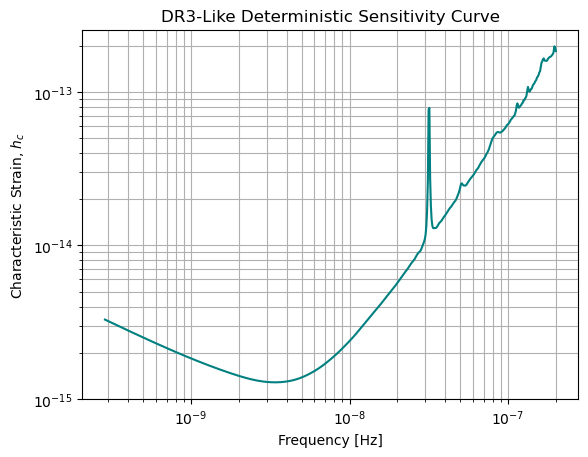

In [28]:
plt.loglog(dr3like_dsc.freqs,dr3like_dsc.h_c,c='teal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('DR3-Like Deterministic Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
# plt.legend()
plt.show()

Now some individual pulsar sensitivity curves, as that is what we actually need to use:

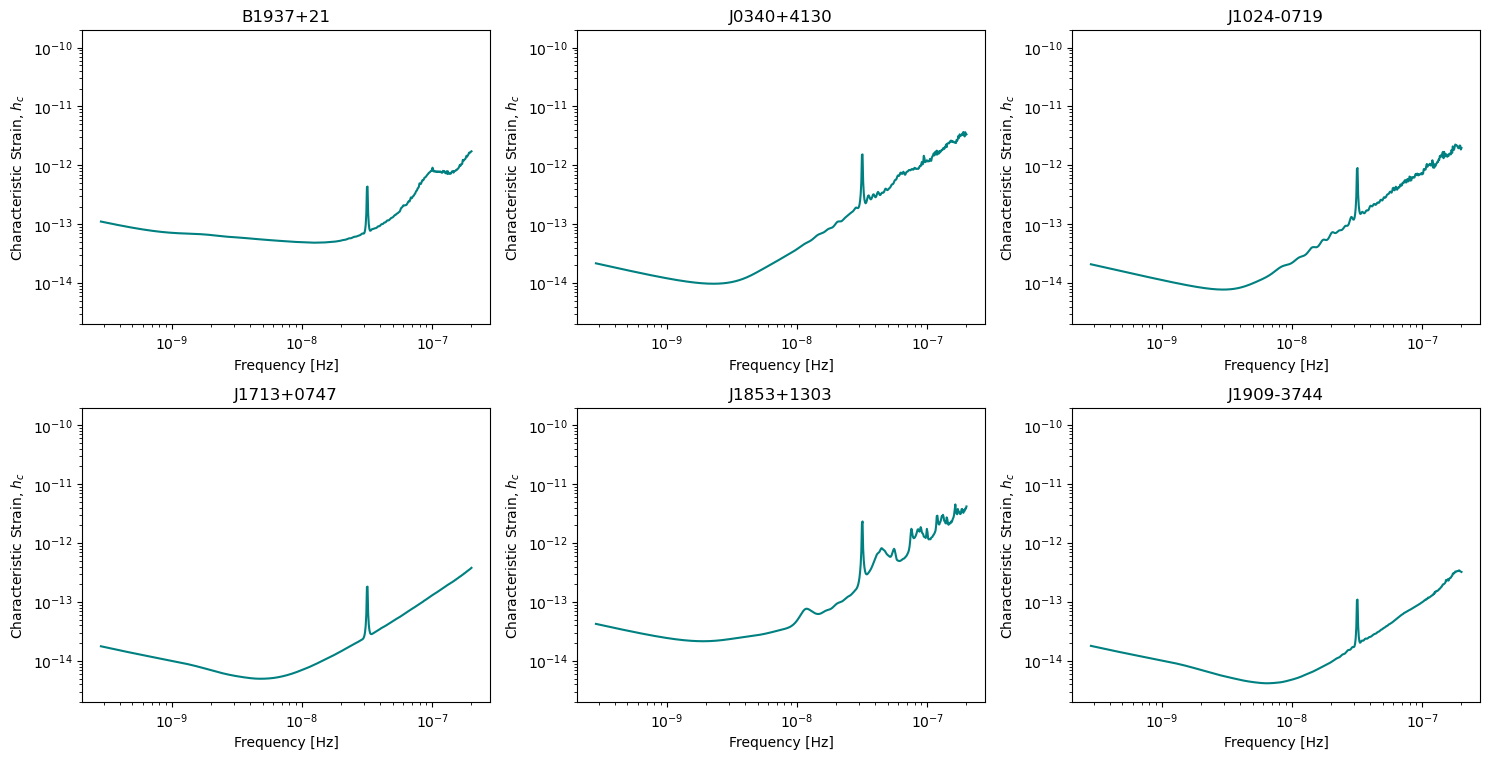

In [32]:
fig=plt.figure(figsize=[15,45])
j = 1
names = ['B1937+21','J0340+4130','J1024-0719',
         'J1713+0747','J1853+1303','J1909-3744',]
for sp,p in zip(specs,psrs):
    if p.name in names:
        dsc_i = hsen.DeterSensitivityCurve([sp])
        fig.add_subplot(12,3,j)
        plt.ylim(2e-15,2e-10)
        plt.loglog(dsc_i.freqs,dsc_i.h_c, color='teal')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Characteristic Strain, $h_c$')
        plt.title(p.name)
        j+=1
fig.tight_layout()
plt.show()
plt.close()

Test: the single-pulsar SNR for a monochromatic signal.

In [35]:
## define the sky
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

Now onto considering the array SNR. We want the combined SNR across the array, added in quadrature, from the PTA echo. This is realized as a set of 